In [1]:
import seaborn as sns
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy
from os import path
%matplotlib inline

In [2]:
def drop_start_end_n(fwd: np.array) -> np.array:
    """!Drops leading and trailing N's of sequences.

    Args:
        fwd (np.array): Forward sequence.

    Returns:
        np.array: Slice of the arguments.

    """
    start = 0
    sums = fwd[0:4].sum(axis=0)
    start = np.argmax(sums > 0)
    end = fwd.shape[1] - 1 - np.argmax(np.flip(sums) > 0)
    return fwd[:, start:end]



In [3]:
def plot_confusion_matrix(cm,
                          classes,
                          ax,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if title is None:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm, cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    ax.set_xticklabels(classes, rotation=45, ha="right")

    # Rotate the tick labels and set their alignment.

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else '.1f'
    thresh = cm.max() / 2.
    text_th = 0.01 if normalize else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > text_th:
                ax.text(j,
                        i,
                        format(cm[i, j], fmt),
                        ha="center",
                        va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [4]:
PROJECTROOTDIR = "."
DATADIR = path.join(PROJECTROOTDIR, "data")
FIGDIR = "./figures"
RESULTS_PATH = './results'

In [5]:
LABELS = ['no repeat', 'HSAT2,3', 'Alphoid', 'Alu', 'LINE-1']

In [6]:
os.makedirs(FIGDIR, exist_ok=True)

In [7]:
sns.set_context('paper')

In [8]:
def preprocess_data(results):
    data = dict()
    time_data = list()
    for dataset, models_dicts in results.items():
        for model, metrics in models_dicts.items():
            for k in metrics:
                if k == 'runtime':
                    time_data.append(
                        [dataset.replace('.fa', ''), model, metrics['runtime']])
                    continue
                if k == 'confusionmatrix':
                    continue
                if k not in data:
                    data[k] = list()
                if isinstance(metrics[k], list):
                    data[k].append([dataset.replace('.fa', ''), model] +
                                   metrics[k][1:])
    for k in data:
        data[k] = pd.DataFrame(data[k],
                               columns=['dataset', 'model'] + LABELS[1:])

    time_data = pd.DataFrame(time_data,
                             columns=['dataset', 'model', 'running time'])
    return data, time_data

In [9]:
def get_cnf_matrices(results):
    confusion_matrices = dict()
    for dataset, models in results.items():
        confusion_matrices[dataset] = np.zeros(
            (len(models), len(LABELS), len(LABELS)))
        for i, metrics in enumerate(models.values()):
            confusion_matrices[dataset][i] = metrics['confusionmatrix']
    return confusion_matrices



# Running time and Accuracy

In [10]:
styles = {'margin_titles': True, 'ylim': (0, 1), 'height': 5}

In [11]:
with open(os.path.join(RESULTS_PATH,'deepgrp_cpu_results.json'), 'rb') as file:
    deepgrp_cpu_data = json.load(file)

with open(os.path.join(RESULTS_PATH,'deepgrp_gpu_results.json'), 'rb') as file:
    deepgrp_gpu_data = json.load(file)

with open(os.path.join(RESULTS_PATH,'dnabrnn_results.json'), 'rb') as file:
    dnabrnn_data = json.load(file)

In [12]:
deepgrp_cpu = preprocess_data(deepgrp_cpu_data)
deepgrp_gpu = preprocess_data(deepgrp_gpu_data)
dnabrnn = preprocess_data(dnabrnn_data)

In [13]:
FPR = deepgrp_cpu[0]['FPR']
FPR[''] = 'FPR'

FNR = deepgrp_cpu[0]['FNR']
FNR[''] = 'FNR'

In [14]:
deepgrp_metrics = FPR.append(FNR).set_index(['', 'dataset']).drop('hg19/chr20',
                                                          axis=0,level=1)
deepgrp_metrics['modeltype']='deepgrp'

In [15]:
FPR = dnabrnn[0]['FPR']
FPR[''] = 'FPR'

FNR = dnabrnn[0]['FNR']
FNR[''] = 'FNR'

In [16]:
dnabrnn_metrics= FPR.append(FNR).set_index(['', 'dataset']).drop('hg19/chr20',
                                                          axis=0,
                                                          level=1)
dnabrnn_metrics['modeltype']='dnabrnn'

In [17]:
metrics = deepgrp_metrics.append(dnabrnn_metrics)

In [18]:
metrics = metrics.reset_index().set_index(['modeltype','','dataset'])

In [19]:
std = metrics.groupby(metrics.index).std()
std.index = pd.MultiIndex.from_tuples(std.index)
mean = metrics.groupby(metrics.index).mean()
mean.index = pd.MultiIndex.from_tuples(mean.index)

In [20]:
metrics = (mean.apply(lambda x: x.map('${:.4f} \pm '.format)) +
           std.apply(lambda x: x.map('{:.4f}$'.format))).replace(
               "$nan \pm nan$", "Na")

In [21]:
metrics = metrics.reindex(["hg19/chr1", "hg38/chr1", "mm10/chr2"], level=2)

In [22]:
with open(path.join(FIGDIR, 'table1.tex'), 'w') as file:
    metrics.to_latex(file,
                     float_format='%.4f',
                     bold_rows=True,
                     multirow=True,
                     escape=False,
                     column_format="llrrrr")

In [23]:
deepgrp_cnfs = get_cnf_matrices(deepgrp_cpu_data)

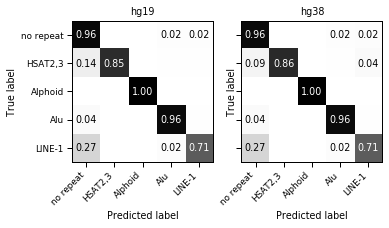

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(5.5, 5.5),sharey=True,sharex=True)
plot_confusion_matrix(deepgrp_cnfs['hg19/chr1.fa'].mean(axis=0),
                      LABELS,
                      ax[0],
                      normalize=True,
                      title='hg19')
ax[0].set_xticklabels([])
plot_confusion_matrix(deepgrp_cnfs['hg38/chr1.fa'].mean(axis=0),
                      LABELS,
                      ax[1],
                      normalize=True,
                      title='hg38')
fig.subplots_adjust(wspace=0.2)
plt.savefig(path.join(FIGDIR, 'figure3.pdf'),
            bbox_inches='tight',
            pad_inches=0)

In [25]:
chr_length = pd.DataFrame()
for chromosome in deepgrp_cpu[1]['dataset'].str.split('/',expand=True)[0].unique():
    tmp = pd.read_csv(
    'http://hgdownload.cse.ucsc.edu/goldenPath/{}/bigZips/{}.chrom.sizes'.format(chromosome,chromosome),
    sep='\t',
    header=None,
    names=['chromosome', 'sequence length'],
    index_col=0)
    tmp.index = '{}/'.format(chromosome)+tmp.index
    chr_length = chr_length.append(tmp)

In [26]:
chr_length['sequence length'] = chr_length['sequence length'] / 1e6

In [27]:
deepgrp_cpu_time = pd.merge(deepgrp_cpu[1],chr_length,left_on='dataset',right_index=True)
deepgrp_gpu_time = pd.merge(deepgrp_gpu[1],chr_length,left_on='dataset',right_index=True)
dnabrnn_time = pd.merge(dnabrnn[1],chr_length,left_on='dataset',right_index=True)

In [28]:
deepgrp_cpu_time_reg = scipy.stats.linregress(
    deepgrp_cpu_time["sequence length"], deepgrp_cpu_time["running time"])
deepgrp_gpu_time_reg = scipy.stats.linregress(
    deepgrp_gpu_time["sequence length"], deepgrp_gpu_time["running time"])
dnabrnn_time_reg = scipy.stats.linregress(dnabrnn_time["sequence length"],
                                          dnabrnn_time["running time"])

In [29]:
deepgrp_cpu_time.insert(0, "modeltype", "DeepGRP")
deepgrp_gpu_time.insert(0, "modeltype", "DeepGRP-GPU")
dnabrnn_time.insert(0, "modeltype", "dna-brnn")

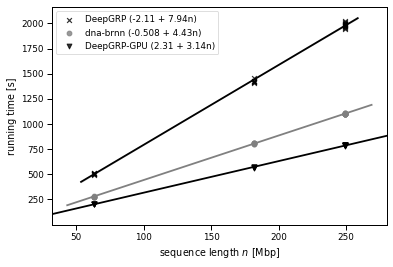

In [30]:
header = "{} ({:.3g} + {:.3g}n)"

ax = sns.regplot(x='sequence length',
                 y='running time',
                 data=deepgrp_cpu_time,
                 marker='x',
                 color='black',
                 label=header.format('DeepGRP', deepgrp_cpu_time_reg[1],
                                     deepgrp_cpu_time_reg[0]))
sns.regplot(x='sequence length',
            y='running time',
            data=dnabrnn_time,
            ax=ax,
            color='grey',
            label=header.format('dna-brnn', dnabrnn_time_reg[1],
                                dnabrnn_time_reg[0]))
sns.regplot(x='sequence length',
            y='running time',
            data=deepgrp_gpu_time,
            marker='v',
            ax=ax,
            color='black',
            label=header.format('DeepGRP-GPU', deepgrp_gpu_time_reg[1],
                                deepgrp_gpu_time_reg[0]))
ax.set(xlabel='sequence length $n$ [Mbp]', ylabel="running time [s]")
ax.legend()

plt.savefig(path.join(FIGDIR, 'figure2.pdf'),
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)

# Complete hg19

In [31]:
def get_mcc_from_json(data):
    mcc = {}
    for dataset, val in data.items():
        mcc[dataset] = dict()
        for model, values in val.items():
            mcc[dataset][model]=np.array(values['MCC'])
    return pd.DataFrame(mcc)

In [32]:
def reformat_columns(mcc):
    mcc.columns = pd.Series(mcc.columns).apply(
        lambda x: int(x.replace('hg19/chr', '').replace('.fa', '')))
    mcc = mcc.unstack().to_frame()[0].apply(lambda x: x.reshape(-1))
    mcc = pd.DataFrame(mcc.values.tolist(), index=mcc.index)
    mcc = mcc.stack(dropna=False).T.reset_index()
    mcc.columns = ['chromosome', 'model', 'repeat class', 'MCC']
    mcc = mcc[mcc['repeat class'] > 0]
    mcc['repeat class'].replace(REPEATS, inplace=True)
    return mcc

In [33]:
REPEATS = {
    1: 'HSAT2,3',
    2: 'Alphoid',
    3: 'Alu',
    4: 'LINE-1',
}

In [34]:
with open(os.path.join(RESULTS_PATH,'deepgrp_results_hg19complete.json'), 'rb') as file:
    deepgrp = json.load(file)
with open(os.path.join(RESULTS_PATH,'dnabrnn_results_hg19complete.json'), 'rb') as file:
    dnabrnn = json.load(file)

In [35]:
deepgrp_mcc = get_mcc_from_json(deepgrp)
dnabrnn_mcc = get_mcc_from_json(dnabrnn)

In [36]:
deepgrp_mcc = reformat_columns(deepgrp_mcc)
dnabrnn_mcc = reformat_columns(dnabrnn_mcc)

In [37]:
dnabrnn_mcc['modeltype']='dnabrnn'
deepgrp_mcc['modeltype']='DeepGRP'
mcc = deepgrp_mcc.append(dnabrnn_mcc)

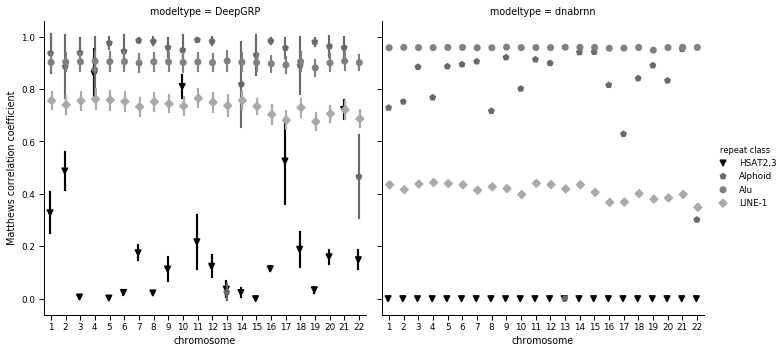

In [38]:
g = sns.catplot(
    x="chromosome",
    y="MCC",
    hue="repeat class",
    col="modeltype",
    data=mcc.fillna(0),
    kind="point",
    ci='sd',
    dodge=True,
    palette=['black', 'dimgrey', 'grey', 'darkgrey'],
    markers=['v', 'p', 'o', 'D'],
    height=5,
    aspect=1,
    linestyles=[''] * 4,
)
g.axes[0][0].set_ylabel('Matthews correlation coefficient')
plt.savefig(path.join(FIGDIR,'figure4.pdf'), dpi=300, bbox_inches='tight')